In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cosima_cookbook as cc
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import scipy.stats as st
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:37593 Dashboard: /proxy/42067/status,Cluster Workers: 6 Cores: 24 Memory: 155.69 GB


In [22]:
# Font size
plt.rcParams['font.size'] = 16
# Axes
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Saving parameters
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

def southern_ocean(ds):
    ds = ds.sel(yu_ocean = slice(None, -50))
    return ds

def amundsen_map():
    
    fig = plt.figure(figsize = (12, 8))
    axs = fig.add_subplot(projection = ccrs.Mercator(central_longitude = 260))
    axs.set_extent([220, 300, -80, -60], crs = ccrs.PlateCarree())
    axs.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                    linewidth = 2, edgecolor = 'black', facecolor = 'none'))
    axs.set_xticks(np.arange(220, 320, 20), crs = ccrs.PlateCarree())
    axs.set_yticks([-75, -70, -65, -60], crs = ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label = False)
    lat_formatter = LatitudeFormatter()
    axs.xaxis.set_major_formatter(lon_formatter)
    axs.yaxis.set_major_formatter(lat_formatter)
    
    return fig, axs

In [3]:
hu = xr.open_dataset('/scratch/e14/jn8053/misc/hu-01deg.nc')['hu']

In [5]:
keys = ['ryf', 'up', 'down']

In [4]:
u = {}
v = {}
u_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.u_10.1990_1991.nc'
u['ryf'] = xr.open_dataset(u_file, decode_times = False)['uas_10m']
v_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.v_10.1990_1991.nc'
v['ryf'] = xr.open_dataset(v_file, decode_times = False)['vas_10m']
u_file_up = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_increased10.u_10.1990_1991.nc'
u['up'] = xr.open_dataset(u_file_up, decode_times = False)['uas_10m']
v_file_up = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_increased10.v_10.1990_1991.nc'
v['up'] = xr.open_dataset(v_file_up,decode_times = False)['vas_10m']
u_file_do = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_decreased10.u_10.1990_1991.nc'
u['down'] = xr.open_dataset(u_file_do, decode_times = False)['uas_10m']
v_file_do = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_decreased10.v_10.1990_1991.nc'
v['down'] = xr.open_dataset(v_file_do,decode_times = False)['vas_10m']

In [17]:
ws  = {}
for k in keys:
    ws[k] =  np.sqrt(u[k].mean('time')**2 + v[k].mean('time')**2)

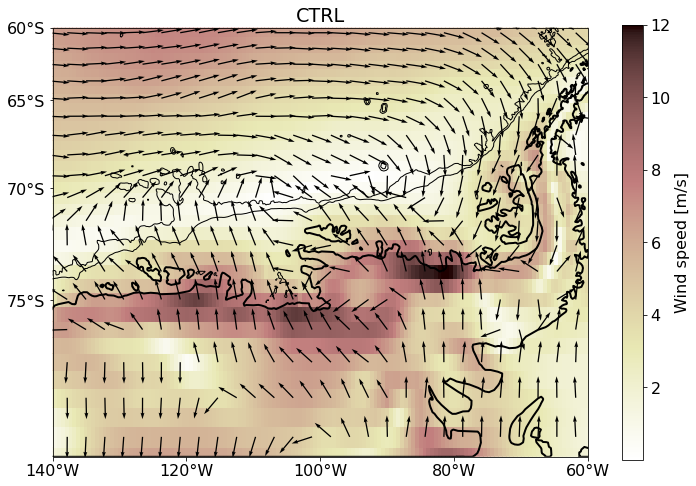

In [48]:
fig, axs = amundsen_map()
cf = axs.pcolormesh(u['ryf']['longitude'], u['ryf']['latitude'], ws['ryf'], 
                    cmap = 'pink_r', vmax = 12, transform = ccrs.PlateCarree())
axs.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 1, transform = ccrs.PlateCarree())
axs.quiver(u['ryf']['longitude'][::5], u['ryf']['latitude'][::2], 
           u['ryf'].mean('time').values[::2, ::5]/ws['ryf'].values[::2, ::5], 
           v['ryf'].mean('time').values[::2, ::5]/ws['ryf'].values[::2, ::5], 
           scale = 25, headwidth = 3, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical')
cbar.set_label('Wind speed [m/s]')
plt.title('CTRL')
plt.savefig(figdir+'easterlies-collaborative/amundsen-wind.png')

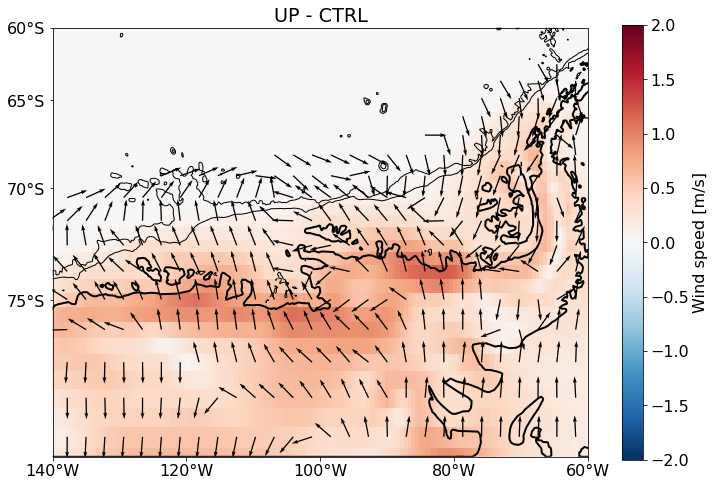

In [49]:
u_anom_up = u['up'].mean('time') - u['ryf'].mean('time')
v_anom_up = v['up'].mean('time') - v['ryf'].mean('time')
ws_anom = np.sqrt(u_anom_up**2 + v_anom_up**2)

fig, axs = amundsen_map()
cf = axs.pcolormesh(u['ryf']['longitude'], u['ryf']['latitude'], ws_anom, 
                    cmap = 'RdBu_r', vmin = -2, vmax = 2, transform = ccrs.PlateCarree())
axs.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 1, transform = ccrs.PlateCarree())
axs.quiver(u['ryf']['longitude'][::5], u['ryf']['latitude'][::2], 
           u_anom_up.values[::2, ::5]/ws_anom.values[::2, ::5], 
           v_anom_up.values[::2, ::5]/ws_anom.values[::2, ::5], 
           scale = 25, headwidth = 3, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical')
cbar.set_label('Wind speed [m/s]')
plt.title('UP - CTRL')
plt.savefig(figdir+'easterlies-collaborative/amundsen-wind-up.png')

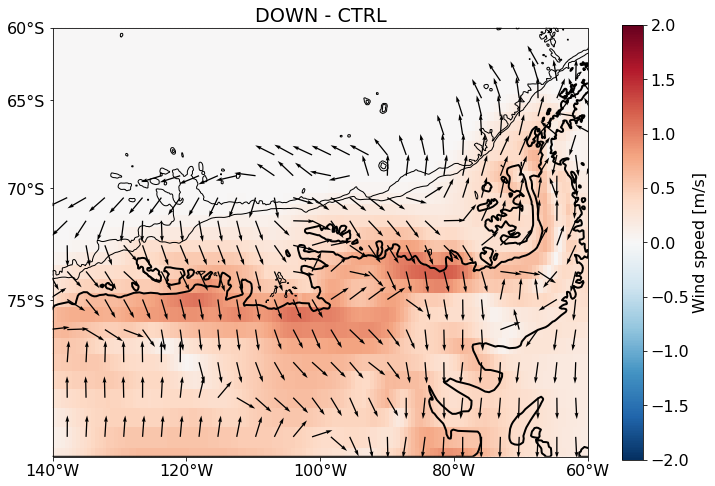

In [50]:
u_anom_do = u['down'].mean('time') - u['ryf'].mean('time')
v_anom_do = v['down'].mean('time') - v['ryf'].mean('time')
ws_anom = np.sqrt(u_anom_do**2 + v_anom_do**2)

fig, axs = amundsen_map()
cf = axs.pcolormesh(u['ryf']['longitude'], u['ryf']['latitude'], ws_anom, 
                    cmap = 'RdBu_r', vmin = -2, vmax = 2, transform = ccrs.PlateCarree())
axs.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 1, transform = ccrs.PlateCarree())
axs.quiver(u['ryf']['longitude'][::5], u['ryf']['latitude'][::2], 
           u_anom_do.values[::2, ::5]/ws_anom.values[::2, ::5], 
           v_anom_do.values[::2, ::5]/ws_anom.values[::2, ::5], 
           scale = 25, headwidth = 3, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical')
cbar.set_label('Wind speed [m/s]')
plt.title('DOWN - CTRL')
plt.savefig(figdir+'easterlies-collaborative/amundsen-wind-down.png')